# Test shifting template experiments

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import umap
import glob
import pickle
import tensorflow as tf
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [ ]:
# Set seeds to get reproducible VAE trained models

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

os.environ["PYTHONHASHSEED"] = "0"

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "human_tests", 
                                           "config_test_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
project_id = params['project_id']
NN_architecture = params['NN_architecture']
sample_id_colname = params['metadata_colname']
scaler_file = params['scaler_transform_file']
num_runs = params['num_simulated']

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "recount2_metadata.tsv")

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

In [4]:
# Input files
rpkm_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_RPKM_data_test.tsv")
assert os.path.exists(rpkm_data_file)

## Setup directories

In [5]:
utils.setup_dir(config_file)

## Pre-process data

In [6]:
# Output file
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data_test.tsv.xz")

In [7]:
train_vae_modules.normalize_expression_data(base_dir,
                                            config_file,
                                            rpkm_data_file,
                                            normalized_data_file)

input: dataset contains 50 samples and 5000 genes
Output: normalized dataset contains 50 samples and 5000 genes


In [8]:
# Output file
experiment_id_file = os.path.join(
    base_dir, 
    dataset_name,
    "data",
    "metadata", 
    "experiment_ids.txt")

In [9]:
utils.create_experiment_id_file(metadata_file,
                                normalized_data_file,
                                experiment_id_file,
                                config_file)

There are 3219 experiments in the compendium
There are 6 experiments with gene expression data
6 experiment ids saved to file


## Train VAE

In [10]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    NN_architecture)

input dataset contains 50 samples and 5000 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 5 samples
Epoch 1/10
45/45 [==============================] - 4s 88ms/step - loss: 2466.1158 - val_loss: 2732.4883
Epoch 2/10
45/45 [==============================] - 4s 79ms/step - loss: 1671.1998 - val_loss: 2180.0183
Epoch 3/10
45/45 [==============================] - 4s 79ms/step - loss: 1566.8178 - val_loss: 1799.2496
Epoch 4/10
45/45 [==============================] - 4s 79ms/step - loss: 1481.5816 - val_loss: 1730.1412
Epoch 5/10
45/45 [==============================] - 4s 78ms/step - loss: 1577.6224 - val_loss: 1477.2603
Epoch 6/10
45/45 [==============================] - 4s 79ms/step - loss: 1444.6422 - val_loss: 1510.6864
Epoch 7/10
45/45 [==============================] - 4s 79ms/step - loss: 1475.2912 - val_loss:

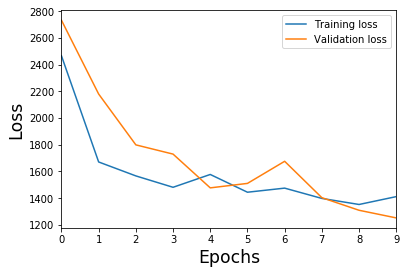

In [11]:
# Train VAE
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

## Shift template experiment

In [12]:
#tmp result dir
tmp = os.path.join(local_dir, "pseudo_experiment")
os.makedirs(tmp, exist_ok=True)

In [13]:
# Run simulation
for run in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_data_file,
        project_id,
        sample_id_colname,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run)

## Visualize latent transform compendium

In [14]:
# Load VAE models
model_encoder_file = glob.glob(os.path.join(
        NN_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [15]:
pca = PCA(n_components=2)

In [16]:
# Read data
normalized_compendium = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

In [17]:
# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=normalized_compendium.index)

# Get and save PCA model
model = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['experiment_id'] = 'background'

In [18]:
# Embedding of real template experiment (encoded)
template_file = os.path.join(local_dir,
    "pseudo_experiment",
    "template_normalized_data_"+project_id+"_test.txt")

template_data = pd.read_csv(template_file, header=0, sep='\t', index_col=0)

# Encode template experiment into latent space
template_encoded = loaded_model.predict_on_batch(template_data)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=template_data.index)

template_PCAencoded = model.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['experiment_id'] = 'template_experiment'

In [19]:
# Embedding of simulated experiment (encoded)
encoded_simulated_file = os.path.join(local_dir,
    "pseudo_experiment",
    "selected_simulated_encoded_data_"+project_id+"_1.txt")

simulated_encoded_df = pd.read_csv(encoded_simulated_file,header=0, sep='\t', index_col=0)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [20]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(60, 3)


,1,2,experiment_id
SRR592745,-1.557785,6.548028,background
SRR592746,-1.335538,6.123819,background
SRR592747,-1.234933,6.325553,background
SRR592748,0.633263,9.497215,background
SRR592749,1.389616,8.344598,background


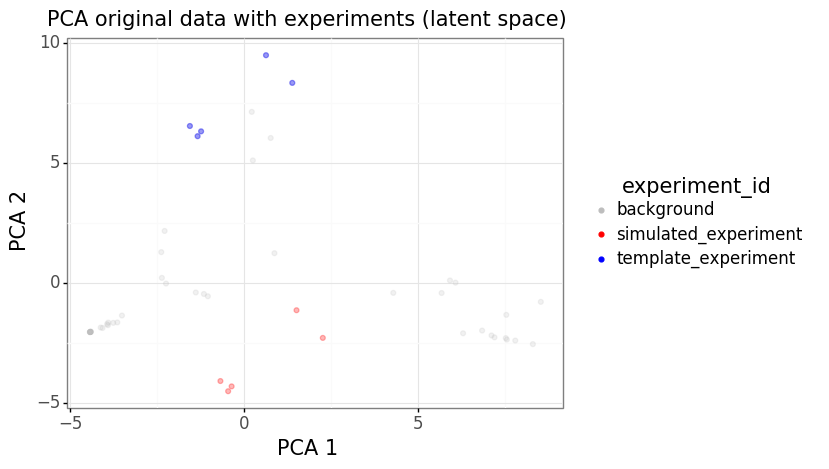

<ggplot: (-9223363306623618528)>


In [21]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.1, 
                  color='red')

print(fig)